In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df = pd.read_csv("day_ahead_market_20210913.csv")

### Decide x_value resolution: 0.25 or 1
### Issue with time change: 23, 24 and 25 hours -> Solved through no_time_change parameter

In [ ]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

### Ito stochastic differential equation (SDE)

An Ito process $X = \{X_t, t \ge 0\}$ has the form
$$ 
    X_t = X_0 + \int_{0}^{t} a(X_s)ds + \int_{0}^{t}b(X_s)dW_s
$$ \
for $t \ge 0$. In differential (SDE) form
$$ 
    dX_t = a(X_t)dt + b(X_t)dW_t
$$ \
where $a$ is called the *drift* of the diffusion process and $b$ the *diffusion coefficient*. $W$ is a Wiener process $W = \{W_t, t \ge 0\}$.
\
\
Consider a time discretisation $(\tau)_{\delta}$ of a time interval $[0, T]$ with
$$ 
    0 = \tau_0 < \tau_1 < \cdots < \tau_n < \cdots < \tau_N = T
$$
\
where the step size is
$$
    \delta = \frac{T}{N}
$$
\
The *Euler-Maruyama approximation* for the SDE
$$ 
    Y_{n+1} = Y_n + a(Y_n)\Delta_{n} + b(Y_n)\Delta W_n
$$
\
for $ n = 0, 1, ..., N-1 $ with initial value
$$ 
    Y_0 = x_0
$$
\
where 
\begin{align}
    \Delta_n &= \tau_{n+1} - \tau_{n} = \delta \\
    \Delta W_{n} &= W_{\tau_{n+1}} - W_{\tau_{n}} \quad \Delta W_{n} \sim N(0;\Delta_{n})
\end{align}


In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
b = s_1.diffusion.mean["diffusion_1"]

In [ ]:
x_df = s_1.df[(s_1.df["date"] >= "2021-03-01")].iloc[:48]
y_0 = x_df["spain"].iloc[0]

In [ ]:
# first draft: simulate n paths
np.random.seed(seed=72)
n = 1000
T = 48
delta = 1
nu = 0
sim_df = pd.DataFrame()
for i in range(n):
    y = np.zeros(48)
    y[0] = y_0
    for t in range(1, T):
        y_t_1 = y[t-1]
        y_t_1_round = y_t_1.round()
        y[t] = y_t_1 + a.loc[y_t_1_round]*delta + np.sqrt(b.loc[y_t_1_round])*np.random.normal(loc=nu, scale=delta)
        if y[t] < 0:
            y[t] = 0
    sim_df[i] = y

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.plot(alpha=0.1, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Vector approach

In [5]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1)

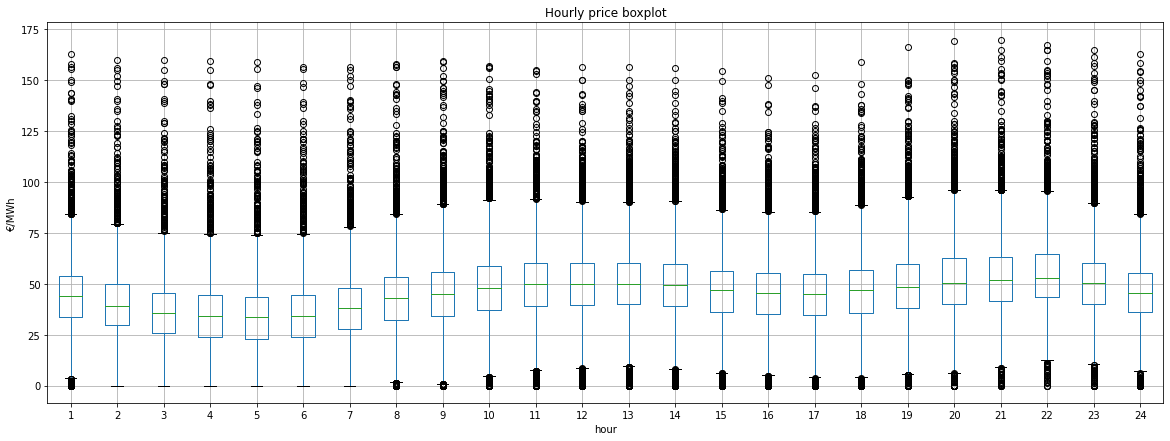

In [6]:
s.plot_hourly_boxplot()

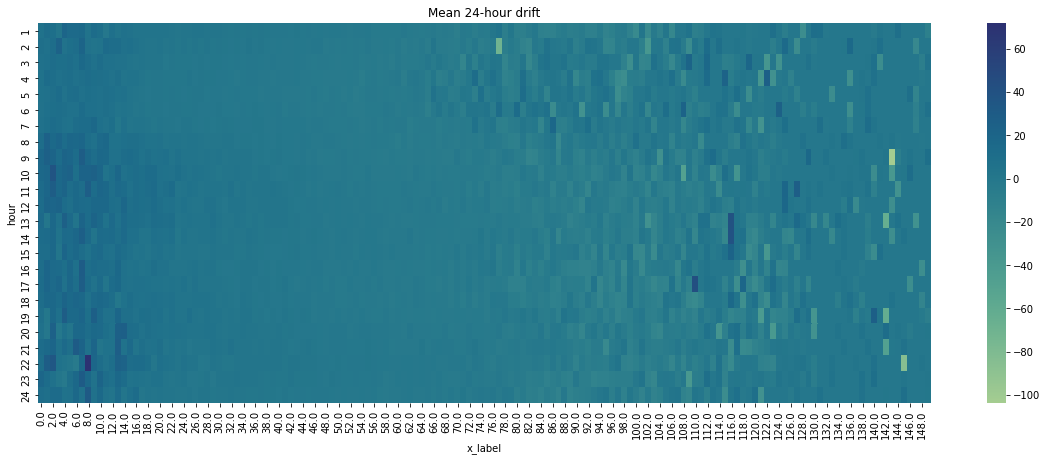

In [7]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :150], ax=ax, cmap='crest')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

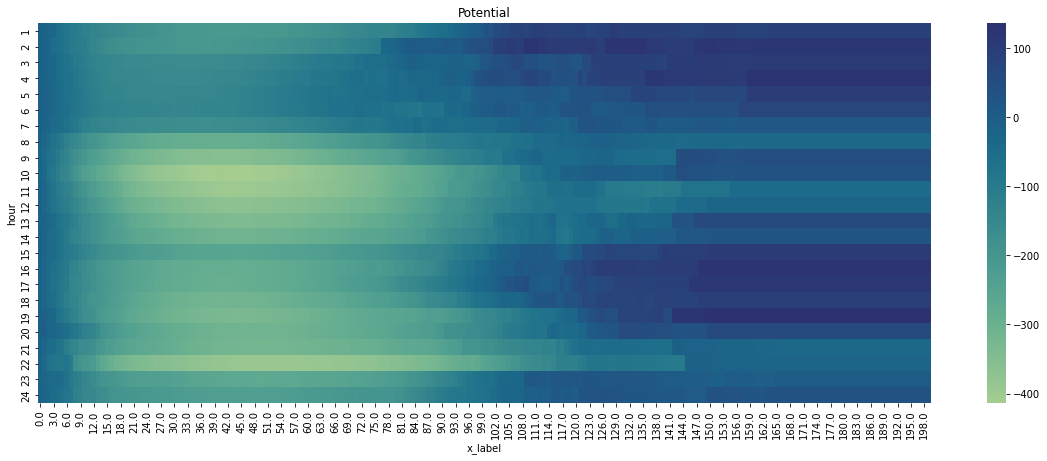

In [8]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x, ax=ax, cmap='crest')
ax.set_title("Potential")
fig.show()

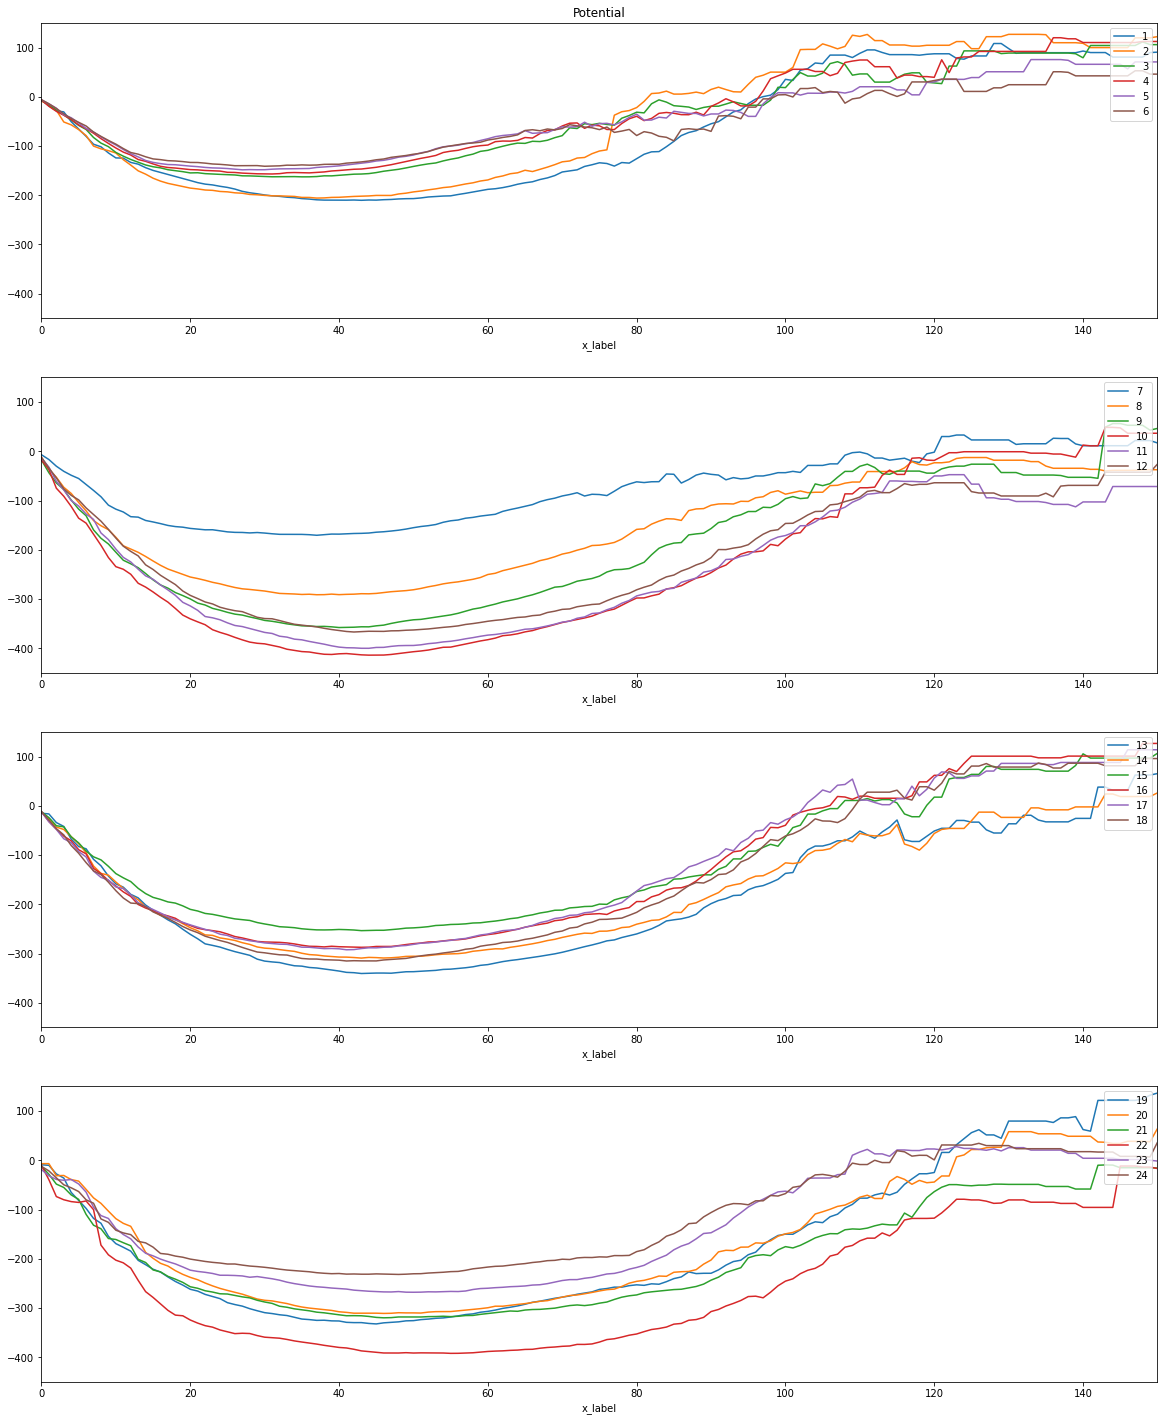

In [9]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 150)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

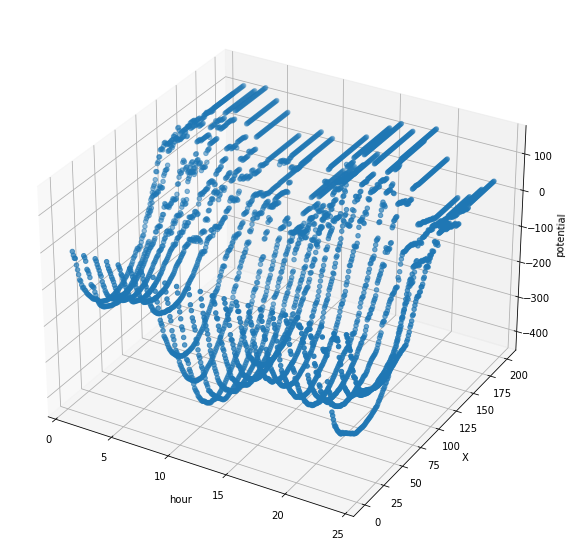

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

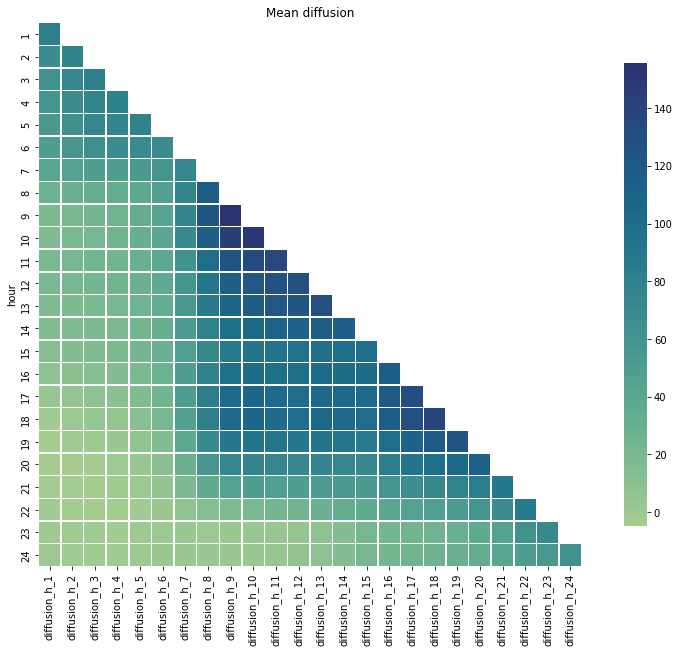

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="crest", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D^{1}(X_{i})$ and constant $D^{2}$

In [12]:
# first draft: simulate n paths in vector form
np.random.seed(seed=72)
n = 1000
T = 7
delta = 1
nu = 0

x_df = s.df[(s.df["date"] >= "2020-01-01")].iloc[:24*T]
y_0 = x_df["spain"].iloc[:24].values

sim_df = pd.DataFrame()
for i in range(n):
    y = np.zeros((24, T))
    y[:, 0] = y_0
    for t in range(1, T):
        y_t_1 = y[:, t-1]
        y_t_1_round = y_t_1.round()
        #y_t_1_round = np.where(y_t_1_round >= 200, 190.0, y_t_1_round)
        y_t = y_t_1 + s.drift_hour_x.lookup(range(1, 25), y_t_1_round)*delta + np.dot(s.sqrt_diff_matrix, np.random.normal(loc=0, scale=1, size=(24, 1))).reshape(-1)
        y_t = np.where(y_t < 0, 0, y_t)
        y[:, t] = y_t
    sim_df[i] = y.flatten("F")

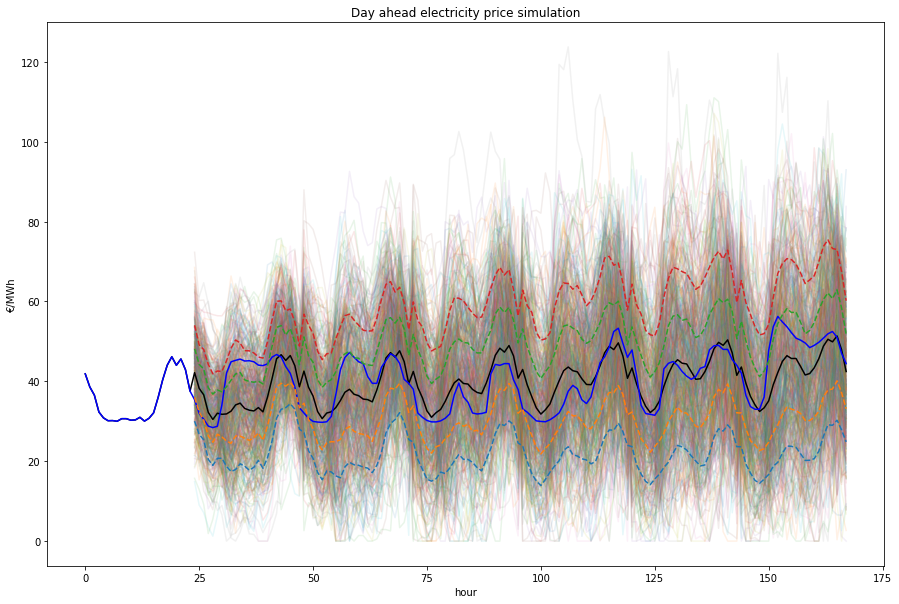

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : n//2].plot(alpha=0.1, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation")
plt.show()

#### Simulation with $D^{1}(X_{i})$ and $D^{2}(X_{i}, X_{j})$

In [14]:
x_df = s.df[(s.df["date"] >= "2020-01-01")].iloc[:24*10]
y_0 = x_df["spain"].iloc[:24].values
y_0_round = y_0.round()

In [15]:
from scipy.linalg import sqrtm, eigvals

In [16]:
diff_m = np.zeros((24, 24))
for i in range(24):
    for j in range(i+1):
        diff_m[i, j] = s.diff_xi_xj[i, j].loc[y_0_round[i], y_0_round[j]]
diff_m = diff_m + np.triu(diff_m.T, k=1)

In [17]:
eigvals(diff_m)

array([1549.37227398+0.j,  804.53961656+0.j, -595.95313699+0.j,
       -397.03184384+0.j,  446.81579064+0.j, -294.68518898+0.j,
       -271.80983256+0.j,  381.46010555+0.j,  320.13469399+0.j,
        300.77263172+0.j, -180.36818205+0.j,  219.49546861+0.j,
       -129.48200469+0.j, -102.88309149+0.j,  -88.2366895 +0.j,
        158.14203341+0.j,  134.152252  +0.j,   89.76296741+0.j,
         86.99169713+0.j,   43.90732076+0.j,   27.33894463+0.j,
         -3.26092191+0.j,  -38.22421839+0.j,  -34.93049609+0.j])

In [18]:
sqrtm(diff_m)

array([[ 8.83336060e+00+8.15946762e+00j,  1.73138115e+00+6.14306436e-01j,
         2.07462360e+00+1.76454088e+00j,  2.13301061e+00+1.25743431e-01j,
        -5.92881964e-01-7.55774070e-01j,  1.28836917e+00-2.24492943e-01j,
         1.60524456e+00-2.11850119e-01j, -1.99400711e-01+2.62258192e-01j,
         7.79083800e+00-6.12791636e+00j,  1.25422384e-01-7.80416975e-01j,
         9.48664392e-02+1.62209269e+00j, -2.94918732e+00+1.01342137e+00j,
        -1.37951241e-01+5.32751279e-01j, -3.38202746e+00+2.96932521e+00j,
        -3.20156505e+00+2.18579414e+00j,  1.59273878e+00-1.22702284e+00j,
        -1.80533163e+00+1.57263073e+00j,  2.73922266e+00-2.05805984e+00j,
         1.74934987e+00+2.50448406e-01j,  2.06808095e-01+1.02755398e-01j,
        -1.40822621e+00-1.52342687e-02j,  9.98019523e-01+1.26576609e+00j,
        -1.38575132e+00+3.84435518e-01j, -2.98163548e-01-5.80781733e-01j],
       [ 1.73138115e+00+6.14306436e-01j,  9.69877905e+00+6.19167222e+00j,
         2.40896948e+00+8.95929840e-0

#### kramersmoyal library

In [19]:
from kramersmoyal import km, kernels

In [20]:
# Choose number of points of you target space
bins = np.array([5000])

# Choose powers to calculate
powers = np.array([[1], [2]])

# Choose your desired bandwith
bw = 0.15

In [21]:
y = s.df["spain"].dropna().values

In [22]:
# The kmc holds the results, where edges holds the binning space
kmc, edges = km(y, kernel = kernels.epanechnikov, bw = bw, bins = bins, powers = powers)

In [23]:
kmc[0]

array([ 0.8736241 ,  0.87384822,  0.87380422, ..., -5.        ,
       -5.        , -5.        ])

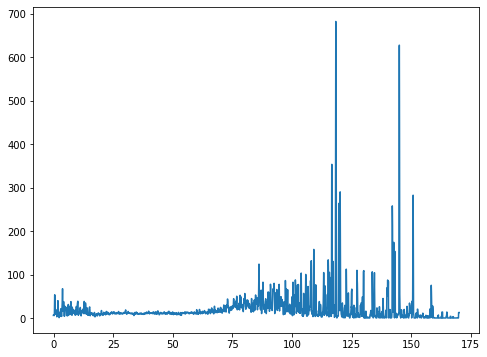

In [24]:
fig, ax = plt.subplots()
ax.plot(edges[0], kmc[1])

In [25]:
# Choose the size of your target space in two dimensions
bins = np.array([300, 300])

# Introduce the desired orders to calculate, but in 2 dimensions
powers = np.array([[0,0], [1,0], [0,1], [1,1], [2,0], [0,2], [2,2]])

bw = 0.1

kmc, edges = km(s.df_vector.T[[1, 2]].dropna().values, bw = bw, bins = bins, powers = powers)

In [26]:
foo = pd.DataFrame(kmc[1])
foo.index = edges[0]
foo.columns = edges[1]
foo = foo.stack().reset_index()
foo[0] = foo[0].replace(0, np.nan)

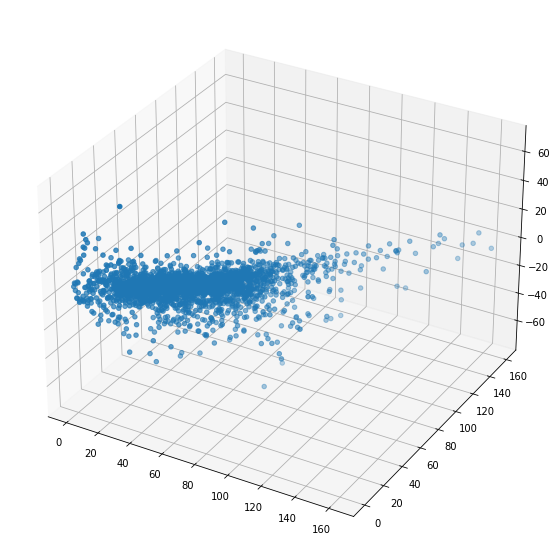

In [27]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
ax.scatter(foo.level_0, foo.level_1, foo.iloc[:, -1])

In [28]:
bar = pd.DataFrame(kmc[3])
bar.index = edges[0]
bar.columns = edges[1]
bar = bar.stack().reset_index()
bar[0] = bar[0].replace(0, np.nan)
bar = bar[bar[0] <= 500]

(-50.0, 500.0)

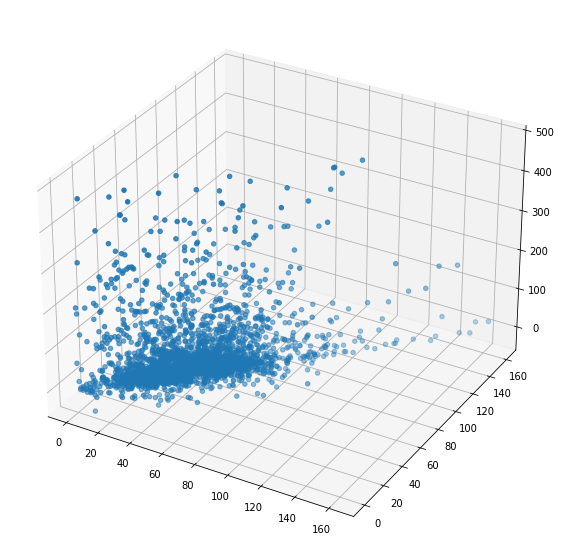

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
ax.scatter(bar.level_0, bar.level_1, bar.iloc[:, -1])
ax.set_zlim(-50, 500)